# Linear Regression

## Model
$$y_i = \beta_{i1}x_{i1} + \beta_{i2}x_{i2} + \beta_{ik}x_{ik} + \epsilon$$
where
$$\epsilon \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)$$

Thus:
$$E(y) = \mathcal{N}(\mathbf{\beta}\mathbf{x})$$
$$Var(y) = \sigma^2$$
$$Corr(y_i, y_j\mid \mathbf{X}, \mathbf{\beta}, \sigma^2) = 0$$

In matrix form:
$$\mathbf{y} = \mathbf{X}\beta + \mathbf{\epsilon}$$

## Bayesian Estimation
### Priors (Conjugate):
$$\mathbf{\beta}\mid\sigma^2 \sim \mathcal{N}(\mu_0, \sigma^2\Omega_0^{-1})$$
$$\sigma^2 \sim Inv-\chi^2(v_0, \sigma_0^2)$$

### Posteriors:
$$\beta\mid\sigma^2, \mathbf{y} \sim \mathcal{N}(\mu_n, \sigma^2\Omega_n^{-1})$$
$$\sigma^2\mid\mathbf{y}\sim Inv-\chi^2(v_n, \sigma^2_n)$$

$$\mu_n = (\mathbf{X}^\top\mathbf{X} + \Omega_0)^{-1}(\mathbf{X}^\top\mathbf{X}\hat{\beta} + \Omega_0\mu_0)$$
$$\Omega_n = \mathbf{X}^\top\mathbf{X} + \Omega_0$$
$$v_n = v_0 + n$$
$$v_n\sigma_n^2 = v_0\sigma_0^2 + (\mathbf{y}^\top\mathbf{y} + \mu_{0}^\top\Omega_0\mu_0 - \mu_n^\top\Omega_n\mu_n)$$

where $\hat{\beta}$ is the least-square approximate of beta $\hat{\beta} = (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}$, $n$ is the number of samples.


In [77]:
%matplotlib inline

import numpy as np
from scipy.linalg import pinv as inv
from scipy.stats import chi2, multivariate_normal
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt

class BayesianPolynomialRegression:
    def __init__(self, n_samples, mu0, omega0, nu0, sigma_sq_0, poly_degree=0, confidence_interval=95):
        self.n_samples = n_samples
        self.confidence_interval = confidence_interval
        self.poly_degree = poly_degree
        
        # prior parameters
        self.mu0 = mu0
        self.omega0 = omega0
        self.nu0 = nu0
        self.sigma_sq_0 = sigma_sq_0
        
    def _sample_from_scaled_inv_chi_sq(self, n, df, scale):
        X = chi2.rvs(size=n, df=df)
        sigma_sq = df * scale / X
        return sigma_sq
    
    def _polynomial_features(self, X, degree):
        n_samples, n_featuers = X.shape
        
        def index_combinations():
            # combinations_with_replacement('ABCD', 2) --> AA AB AC AD BB BC BD CC CD DD
            combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree+1)]
            flat_combs = [item for sublist in combs for item in sublist]
            return flat_combs
        
        combinations = index_combinations()
        n_output_features = len(combinations)
        X_new = np.empty((n_samples, n_output_features))
        
        for i, index_combs in enumerate(combinations):
            X_new[:, i] = np.prod(X[:, index_combs], axis=1)
            
        return X_new
        
    def fit(self, X, y):
        if self.poly_degree > 0:
            X = self._polynomial_features(X, degree=self.poly_degree)

        n_samples, n_features = X.shape
        Xt_X = X.T.dot(X)
        
        beta_hat = inv(Xt_X).dot(X.T).dot(y) # Moore-Penrose pseudo-inverse of (X^\top X)
        
        # posteriors
        mu_n = inv(Xt_X + self.omega0).dot( \
                Xt_X.dot(beta_hat) + self.omega0.dot(self.mu0))
        omega_n = Xt_X + self.omega0
        
        nu_n = self.nu0 + n_samples
        sigma_sq_n = (1.0 / nu_n) * \
            (self.nu0*self.sigma_sq_0 + \
            (y.T.dot(y) + self.mu0.T.dot(self.omega0).dot(self.mu0) - mu_n.T.dot(omega_n).dot(mu_n)))
        
        # draw samples from the posterior distributions
        beta_samples = np.empty((self.n_samples, n_features))
        for i in range(self.n_samples):
            sigma_sq = self._sample_from_scaled_inv_chi_sq(n=1, df=nu_n, scale=sigma_sq_n)
            beta = multivariate_normal.rvs(size=1, mean=mu_n[:, 0], cov=sigma_sq*inv(omega_n))
            
            beta_samples[i, :] = beta
            
        # mean of beta
        self.beta = np.mean(beta_samples, axis=0)
        
        # lower and upper boundary of the confidence interval
        lower_est = 50 - self.confidence_interval/2
        upper_est = 50 + self.confidence_interval/2
        self.est = np.array([[np.percentile(beta_samples[:, i], q=lower_est), np.percentile(beta_samples[:, i], q=upper_est)] \
                           for i in range(n_features)])
    
    def predict(self, X, do_confidence_est=False):
        if self.poly_degree > 0:
            X = self._polynomial_features(X, degree=self.poly_degree)
        
        y_pred = X.dot(self.beta)
        
        if do_confidence_est:
            lower_beta = self.est[:, 0]
            upper_beta = self.est[:, 1]
            
            y_lower_pred = X.dot(lower_beta)
            y_upper_pred = X.dot(upper_beta)
            return y_pred, y_lower_pred, y_upper_pred
        
        return y_pred
            

In [78]:
%matplotlib inline
import pandas as pd

SEED = 42
np.random.seed(SEED)

def train_test_split(X, y, test_prop=0.1):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    shuffled_X = X[indices]
    shuffled_y = y[indices]
    
    num_test_samples = int(num_samples * test_prop)
    X_test, X_train = X[:num_test_samples], X[num_test_samples:]
    y_test, y_train = y[:num_test_samples], y[num_test_samples:]
    
    return X_train, X_test, y_train, y_test
    

data = pd.read_csv('../data/TempLinkoping2016.csv', sep="\t")

data.sample(5)

,time,temp
193,0.530055,16.6
33,0.092896,0.8
15,0.043716,-14.6
310,0.849727,-0.8
57,0.158470,-0.7


In [79]:
time = np.atleast_2d(data["time"].values).T
temp = np.atleast_2d(data["temp"].values).T
X = time
y = temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_prop=0.1)

n_samples, n_features = X.shape

# priors
mu0 = np.array([0] * n_features)
omega0 = np.diag([.0001] * n_features)

nu0 = 1
sigma_sq_0 = 100

confidence_interval = 10


In [80]:
def plot_figure(X, X_train, y_train, X_test, y_test, y_pred, lower_y_pred, upper_y_pred, title=None):
    cmap = plt.get_cmap('viridis')
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    
    m1 = ax.scatter(366 * X_train, y_train, color=cmap(0.9), s=10, label='Training samples')
    m2 = ax.scatter(366 * X_test, y_test, color=cmap(0.5), s=10, label='Testing samples')
    p1 = ax.plot(366*X, y_pred, color="black", linewidth=2, label="Prediction")
    p2 = ax.plot(366*X, lower_y_pred, color="gray", linewidth=2, label="{0}% confidence interval".format(confidence_interval))
    p3 = ax.plot(366*X, upper_y_pred, color="gray", linewidth=2)
    
    ax.axis((0, 366, -20, 25))
    ax.set_xlabel("Day")
    ax.set_ylabel("Temperature")
    ax.legend(loc="lower right")
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title("Bayesian Polynomial Regression")

    plt.show()

# Linear model

## Degree = 1

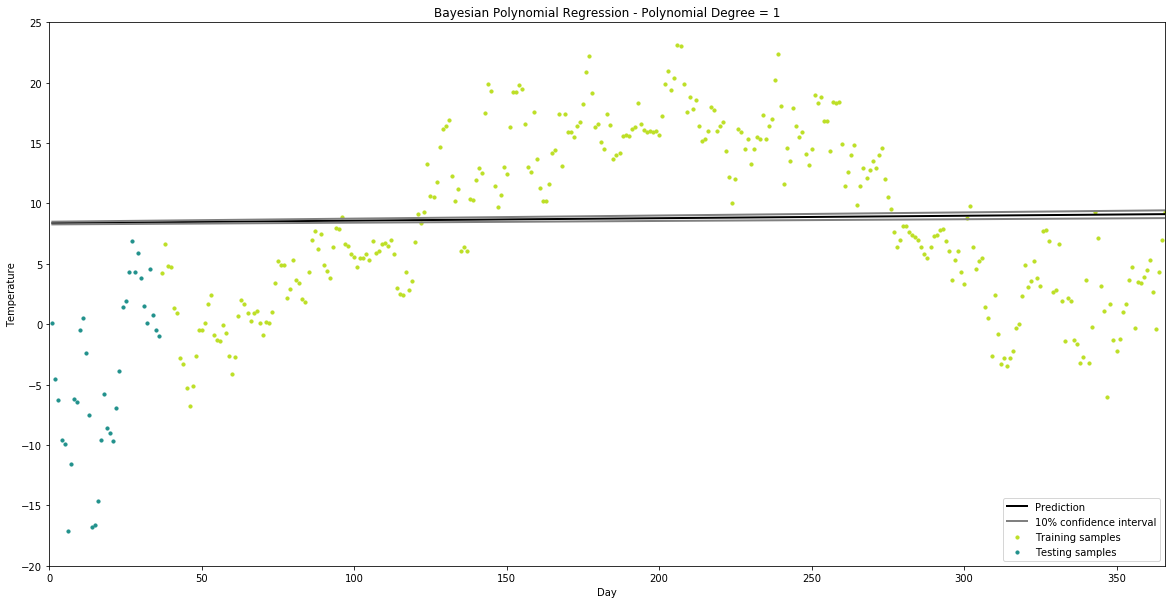

In [81]:
linear_estimator = BayesianPolynomialRegression(
    n_samples=1000,
    poly_degree=1,
    mu0=mu0,
    omega0=omega0,
    nu0=nu0,
    sigma_sq_0=sigma_sq_0,
    confidence_interval=confidence_interval)
linear_estimator.fit(X_train, y_train)
y_pred, lower_y_pred, upper_y_pred = linear_estimator.predict(X, do_confidence_est=True)

plot_figure(X, X_train, y_train, X_test, y_test, y_pred, lower_y_pred, upper_y_pred, "Bayesian Polynomial Regression - Polynomial Degree = 1")


## Degree = 2

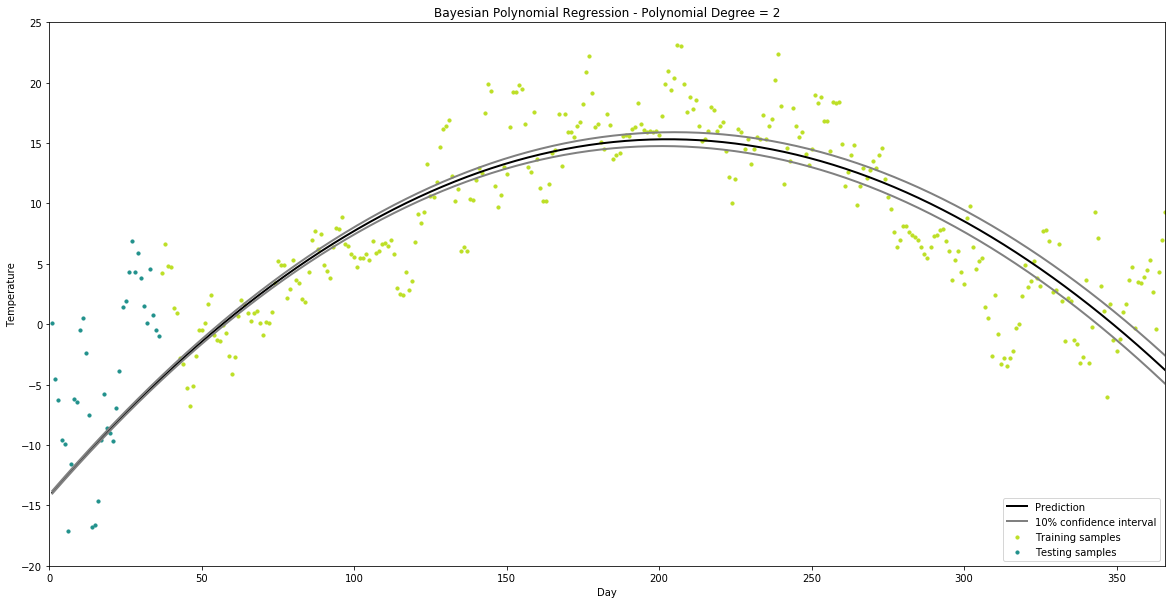

In [82]:
linear_estimator = BayesianPolynomialRegression(
    n_samples=1000,
    poly_degree=2,
    mu0=mu0,
    omega0=omega0,
    nu0=nu0,
    sigma_sq_0=sigma_sq_0,
    confidence_interval=confidence_interval)
linear_estimator.fit(X_train, y_train)
y_pred, lower_y_pred, upper_y_pred = linear_estimator.predict(X, do_confidence_est=True)

plot_figure(X, X_train, y_train, X_test, y_test, y_pred, lower_y_pred, upper_y_pred, "Bayesian Polynomial Regression - Polynomial Degree = 2")


## Degree = 5

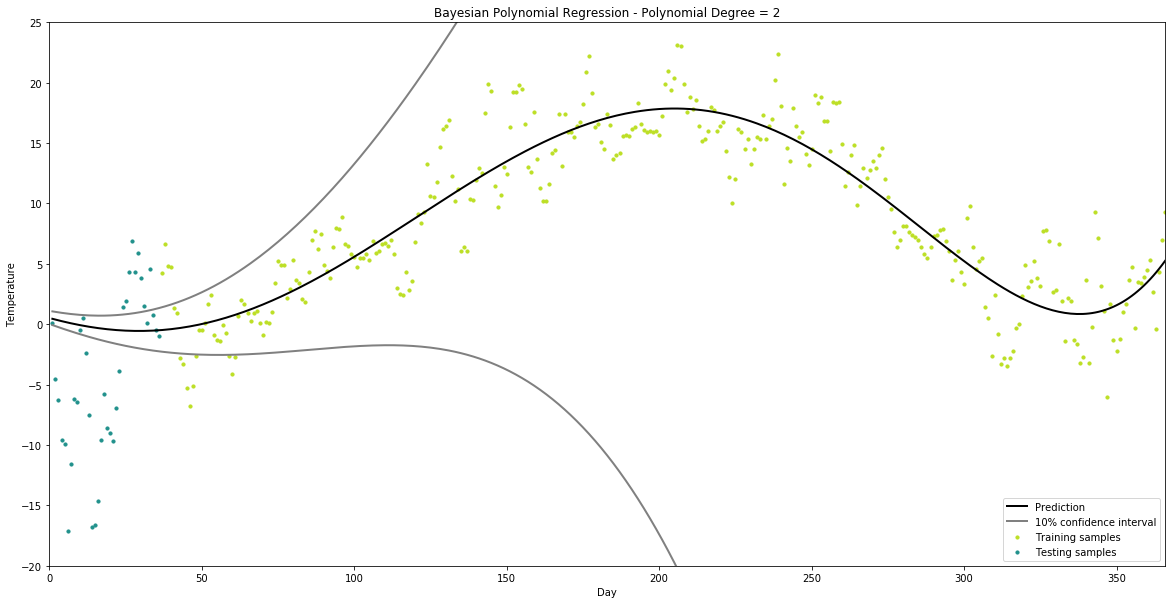

In [85]:
linear_estimator = BayesianPolynomialRegression(
    n_samples=1000,
    poly_degree=5,
    mu0=mu0,
    omega0=omega0,
    nu0=nu0,
    sigma_sq_0=sigma_sq_0,
    confidence_interval=confidence_interval)
linear_estimator.fit(X_train, y_train)
y_pred, lower_y_pred, upper_y_pred = linear_estimator.predict(X, do_confidence_est=True)

plot_figure(X, X_train, y_train, X_test, y_test, y_pred, lower_y_pred, upper_y_pred, "Bayesian Polynomial Regression - Polynomial Degree = 2")
